# System Identification Problem

In [11]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


In [1]:
using RxInfer, Distributions, StableRNGs, Plots

In [2]:
function generate_data(n; seed = 123)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    real_x_τ = 0.1
    real_w_τ = 1.0
    noise = 20.0

    x_i_min = -20.0
    w_i_min = 20.0

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_y[i] = rand(rng, Normal(real_x[i] + real_w[i], sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_y
end

generate_data (generic function with 1 method)

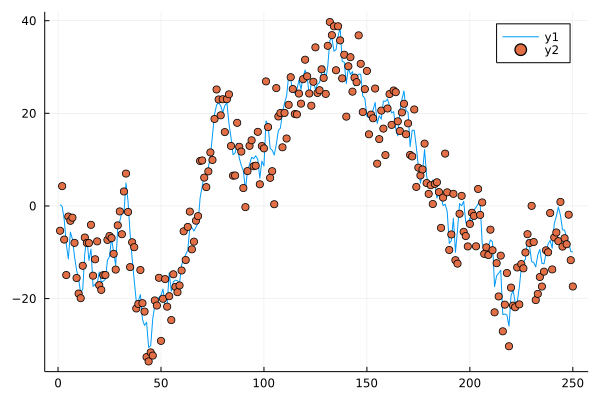

In [3]:
n = 250
real_x, real_w, real_y = generate_data(n);

p = plot()
p = plot!(p, real_x .+ real_w)
p = scatter!(p, real_y)

In [4]:
@model function identification_problem(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x = randomvar(n)
    w = randomvar(n)
    s = randomvar(n)
    y = datavar(Float64, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x[i] ~ Normal(mean = x_i_min, precision = τ_x)
        w[i] ~ Normal(mean = w_i_min, precision = τ_w)
        s[i] ~ x[i] + w[i]
        y[i] ~ Normal(mean = s[i], precision = τ_y)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
end

In [5]:
constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)q(τ_y)
end;

In [6]:
m_x_0, τ_x_0 = -20.0, 1.0
m_w_0, τ_w_0 = 20.0, 1.0

a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)
a_y, b_y = 1.0, 1.0

# We set relatively strong priors for messges
xinit = map(r -> NormalMeanPrecision(r, τ_x_0), reverse(range(-60, -20, length = n)))
winit = map(r -> NormalMeanPrecision(r, τ_w_0), range(20, 60, length = n))

imessages = (x = xinit, w = winit)
imarginals = (τ_x = GammaShapeRate(a_x, b_x), τ_w = GammaShapeRate(a_w, b_w), τ_y = GammaShapeRate(a_y, b_y))

result = inference(
    model = identification_problem(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y),
    data  = (y = real_y,), 
    options = model_options(limit_stack_depth = 100,),
    constraints = constraints, 
    initmessages = imessages, 
    initmarginals = imarginals, 
    iterations = 20
);

In [7]:
τ_x_marginals, τ_w_marginals = result.posteriors[:τ_x], result.posteriors[:τ_w]

xmarginals, wmarginals = result.posteriors[:x], result.posteriors[:w];

In [8]:
mean.(τ_x_marginals)[end], mean.(τ_w_marginals)[end]

(0.21139397020034617, 0.31746938833110916)

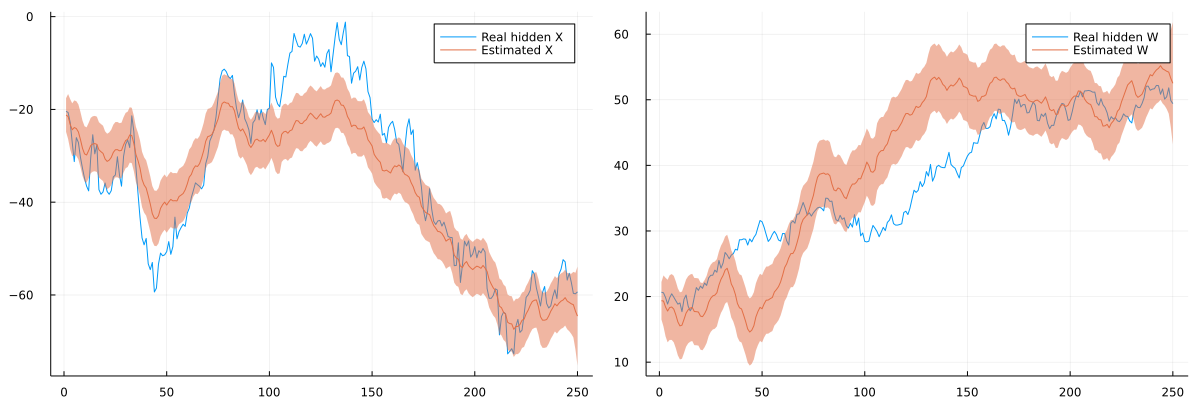

In [9]:
px1 = plot()
px2 = plot()

px1 = plot!(px1, real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(xmarginals[end]), ribbon = var.(xmarginals[end]), label = "Estimated X")

px2 = plot!(px2, real_w, label = "Real hidden W")
px2 = plot!(px2, mean.(wmarginals[end]), ribbon = var.(wmarginals[end]), label = "Estimated W")

plot(px1, px2, size = (1200, 400))

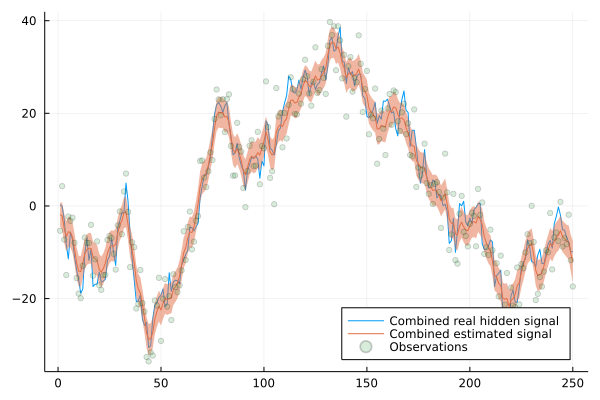

In [10]:
p = plot(legend = :bottomright)

p = plot!(p, real_x .+ real_w, label = "Combined real hidden signal")
p = plot!(p, mean.(xmarginals[end]) + mean.(wmarginals[end]), ribbon = (var.(xmarginals[end]) + var.(wmarginals[end])) .|> sqrt, label = "Combined estimated signal")
p = scatter!(p, real_y, label = "Observations", ms = 3, alpha = 0.2)